## Estimating the source of generated imageas

How distinctive are images from Midjourney vs. Stable Diffusion vs. Dall-E?

Very distinctive it seems. I modified the classifier from the [Lesson 1 notebook](https://github.com/fastai/course22/blob/master/00-is-it-a-bird-creating-a-model-from-your-own-data.ipynb) to find the sources of images

In [20]:
#!pip install fastai duckduckgo_search

import itertools
from pathlib import Path

from duckduckgo_search import ddg_images

from fastai.vision.all import *
from fastai import *
from fastcore.all import *
from fastai.vision.utils import download_images, resize_images, verify_images
from fastai.data.transforms import get_image_files
from fastai.vision.augment import Resize, RandomResizedCrop
from fastai.data.transforms import RandomSplitter, parent_label
from fastai.vision.data import ImageBlock
from fastai.data.block import DataBlock, CategoryBlock
from fastdownload import download_url


In [2]:

# SETTINGS

imgs_per_category = 100
categories = (
    # keep in alphabetical order, so it's easier to interpret the results
    'Dall-E', 'Midjourney', 'Stable Diffusion',
)

search_terms = (
    'Generated with %s',
)

In [3]:

# download images from duckduckgo

def search_images(term, max_images=200):
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

source_path = Path('midge_or_not')
for label in categories:
    dest = source_path/label
    dest.mkdir(exist_ok=True, parents=True)
    urls = []
    for search_term in search_terms:
        urls.extend(search_images(search_term % label, imgs_per_category))
    download_images(dest, urls=urls)
    resize_images(dest, max_size=400, dest=dest)

failed = verify_images(get_image_files(source_path))
failed.map(Path.unlink)
print(f'removed {len(failed)} bad images')

removed 16 bad images


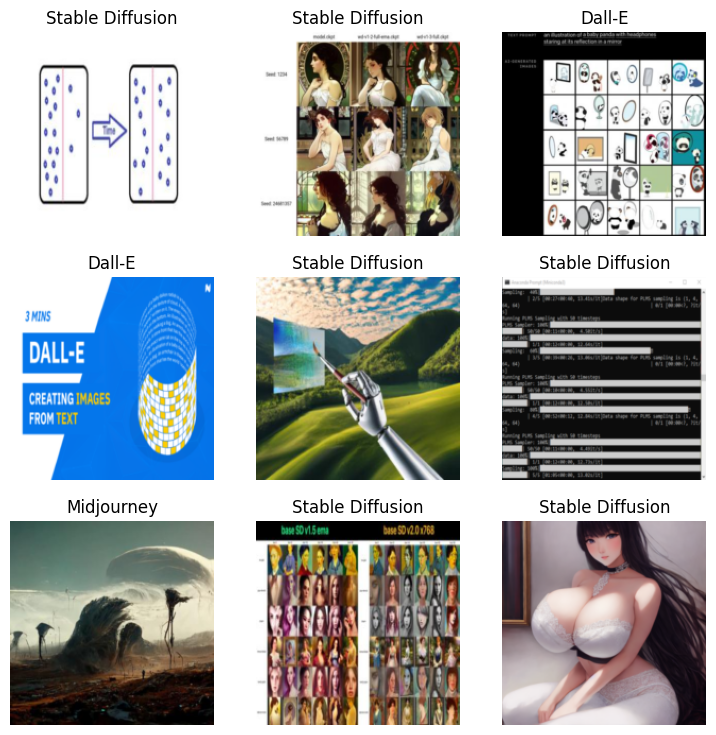

In [5]:

loader_basic = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(source_path)
loader_basic.show_batch()


Eyeballing these, it's clear that there are distinctive styles. But the data is also noisy in ways that might let us cheat our way to a classifier
e.g. there's a screenshot of the midjourney discord. And for Dall-E there is the omnipresent avocado chair, which I would not be at all surprised to see repeated elsewhere in the dataset

Still, let's at least try training with this

In [21]:
learn = vision_learner(loader_basic, resnet18, metrics=error_rate)

In [22]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.169168,0.055985,0.000000,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.129368,0.006204,0.000000,00:04
1,0.066795,0.001058,0.000000,00:05
2,0.037652,0.000316,0.000000,00:05
3,0.022670,0.000187,0.000000,00:05
4,0.014488,0.000197,0.000000,00:05
5,0.009436,0.000157,0.000000,00:05
6,0.006652,0.000125,0.000000,00:04
7,0.004498,0.000094,0.000000,00:04
8,0.003267,0.000103,0.000000,00:04
9,0.002261,0.000106,0.000000,00:05


Perfection! or near-perfection. To confirm, I'll download a few images manyually


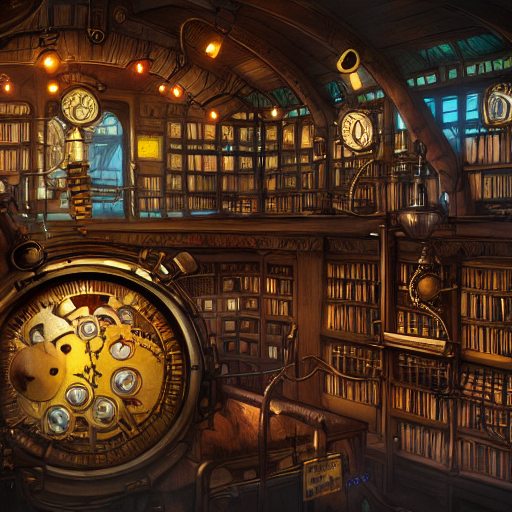

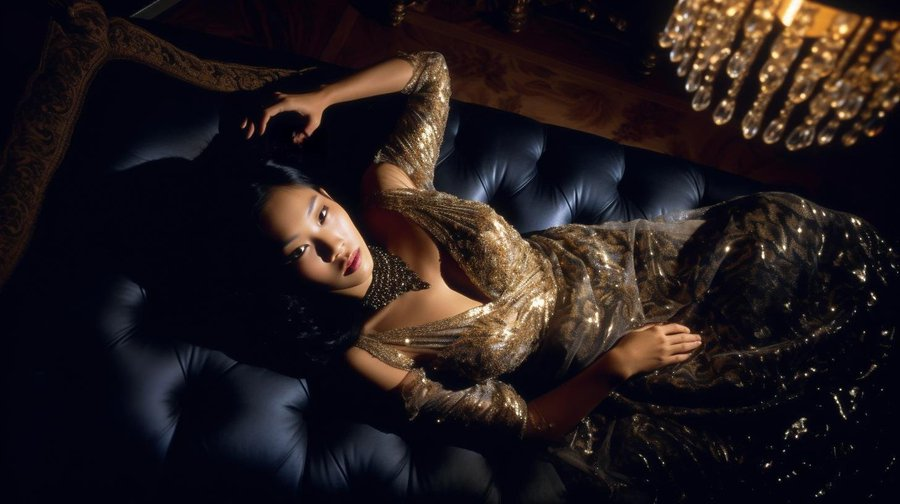

In [28]:

example_images = {
    'eg_stable_diffusion.jpg': 'https://strikingloo.github.io/resources/ai-generated-images/stable-diffusion/selected/1397887120__A_digital_illustration_of_a_steampunk_library_with_clockwork_machines__4k__detailed__trending_in_artstation__fantasy_vivid_colors_.png',
    'eg_midjourney.jpg': 'https://pbs.twimg.com/media/Fs4scdEWYAIcANt?format=jpg&name=900x900',
    'eg_dalle.jpg': 'https://i.pcmag.com/imagery/articles/009eKY0vyQqiSfEUCJhq225-1.fit_lim.size_1600x900.v1666985690.png'
}    
for fn, url in example_images.items():
    download_url(url, fn)
    # confession: I nudged this with some manual resizing
    # without it, the results were noticeably worse
    display(Image.open(fn))    

In [29]:
# how do we do?
results = [(k, learn.predict(PILImage.create(k))) for k in example_images.keys()]
results

[('eg_stable_diffusion.jpg',
  ('Midjourney', tensor(1), tensor([0.0240, 0.9068, 0.0693]))),
 ('eg_midjourney.jpg',
  ('Midjourney', tensor(1), tensor([0.3108, 0.6755, 0.0137])))]

## Distinguishing image fragments

Now, let's see what happens if we train the learner only on **parts** of each image?

What do that? Firstly, because I'm worried that we've been learning superficial features of the images -- the standard dimensions, or resolution, or the 4-image grids that people usually make with Midjourney.

Second, just to make it a bit more challenging, see what the learner can do with one hand tied behind its back.

Third, as one way to start examining _what_ differences we are finding between the generators. e.g. what is layout, wwhat is color palette?

To do this, I'm going to replace the transformer that pre-processes each image, with a variety of sizes

Let's make a bunch of loaders, each of which is going to have the images cropped down to a different size.


In [10]:
image_sizes = [10,20,50,100,192]

loaders = {
    size:
    DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2),
    get_y=parent_label,
    item_tfms=[RandomResizedCrop(size)]).dataloaders(source_path) for 
    size in image_sizes}

From a very blocky 10-pixel one

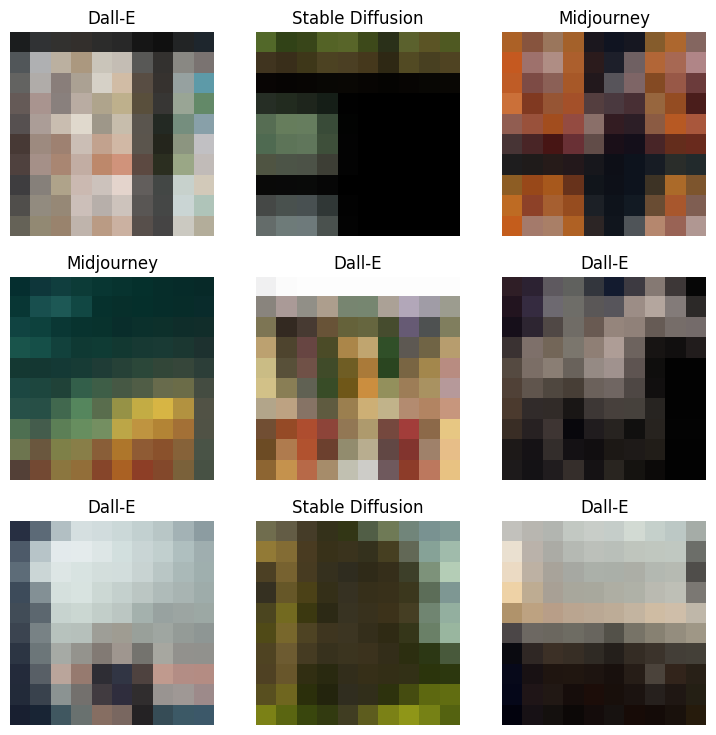

In [11]:
loaders[10].show_batch()

...to something as big as our first version, just resized differently

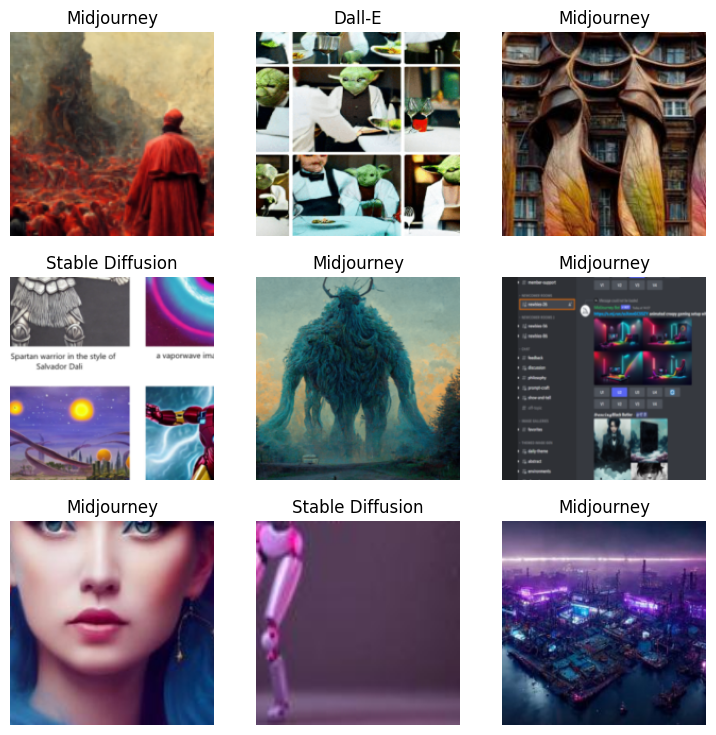

In [12]:
loaders[192].show_batch()


Even using the large size, results are worse than using Jeremy's original code. 

In [13]:
learn = vision_learner(loaders[192], resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.387459,0.368052,0.137026,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.686901,0.223211,0.084548,00:04
1,0.497004,0.145354,0.032070,00:04
2,0.373984,0.062632,0.020408,00:04
3,0.280810,0.033281,0.005831,00:04
4,0.220304,0.052673,0.005831,00:04
5,0.183342,0.039766,0.005831,00:04
6,0.159998,0.039482,0.005831,00:04
7,0.140973,0.030639,0.005831,00:04
8,0.109655,0.033158,0.005831,00:04
9,0.090184,0.032458,0.005831,00:04


As we get gradually smaller, the results are worse

In [14]:
learn = vision_learner(loaders[100], resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.546477,0.585519,0.195335,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.886635,0.378855,0.128280,00:03
1,0.714352,0.184495,0.061224,00:03
2,0.537151,0.061933,0.014577,00:03
3,0.423415,0.059085,0.005831,00:03
4,0.342363,0.040179,0.005831,00:03
5,0.280062,0.033495,0.005831,00:03
6,0.225336,0.039941,0.020408,00:03
7,0.183924,0.042166,0.017493,00:03
8,0.155521,0.036036,0.017493,00:03
9,0.142055,0.031919,0.002915,00:03


In [15]:
learn = vision_learner(loaders[50], resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.542137,0.745039,0.297376,00:02


epoch,train_loss,valid_loss,error_rate,time
0,1.146361,0.539771,0.206997,00:03
1,0.970010,0.365296,0.128280,00:03
2,0.802303,0.264226,0.102041,00:02
3,0.689099,0.194027,0.064140,00:03
4,0.578683,0.135613,0.040816,00:03
5,0.497541,0.151654,0.034985,00:02
6,0.432447,0.113330,0.029155,00:02
7,0.374416,0.110732,0.026239,00:02
8,0.339017,0.111675,0.026239,00:02
9,0.312936,0.100905,0.026239,00:02


In [16]:
learn = vision_learner(loaders[20], resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.761566,0.866705,0.390671,00:02


epoch,train_loss,valid_loss,error_rate,time
0,1.365479,0.838992,0.352770,00:02
1,1.299568,0.717423,0.282799,00:02
2,1.239020,0.612500,0.227405,00:03
3,1.157926,0.567374,0.221574,00:03
4,1.081637,0.523600,0.204082,00:02
5,0.979573,0.479839,0.201166,00:02
6,0.909560,0.425735,0.177843,00:03
7,0.825585,0.408152,0.189504,00:03
8,0.762481,0.390641,0.169096,00:03
9,0.728882,0.393636,0.163265,00:03


In [17]:
learn = vision_learner(loaders[10], resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.808331,1.041489,0.518950,00:02


epoch,train_loss,valid_loss,error_rate,time
0,1.524018,1.027790,0.486880,00:02
1,1.463796,0.951889,0.393586,00:02
2,1.414243,0.997678,0.440233,00:02
3,1.347925,0.948729,0.352770,00:02
4,1.264288,0.784042,0.306122,00:02
5,1.216519,0.769260,0.303207,00:02
6,1.180032,0.741572,0.329446,00:02
7,1.133751,0.684734,0.265306,00:02
8,1.077411,0.682271,0.314869,00:02
9,1.036192,0.676631,0.291545,00:02


It seems that even with a tiny grid, we have a decent chance of telling them apart. Dall-e images are the most distinctive. Stable Diffusion is least distinctive, perhaps because people are doing so many different things with it

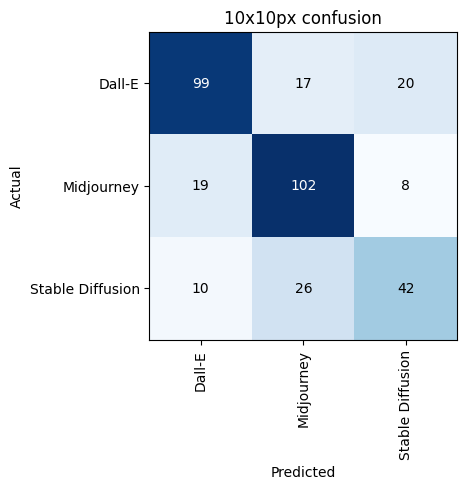

In [18]:
ClassificationInterpretation.from_learner(learn).plot_confusion_matrix(title='10x10px confusion')